# Conservative Interpolation

A common requirement for interpolation in astrophysics is that it is conservative.  Let's see what that means.

Imagine that we divide our domain into uniformly sized bins, and in each bin we place some mass.  We can describe the mass by its density, and in each of the bins, we store the average density, $\langle \rho \rangle$:

![density in equally spaced bins](density_interpolation.png)

Here, $x_{i-1/2}$ is the coordinate of the left edge of bin $i$, and $x_{i+1/2}$ is the coordinate of the right edge of bin $i$.  The mass in bin $i$ would be computed as:

$$m_i = \int_{x_{i-1/2}}^{x_{i+1/2}} \rho(x) dx$$

and the average density in that bin would be:

$$\langle \rho \rangle_i = \frac{m_i}{\Delta x}$$

Imagine that we want to construct a cubic interpolant through zones $i-2$, $i-1$, $i$, and $i+1$ that conserves mass, i.e., when we integrate the interpolant over each of the bins, it gives us the correct amount of mass for that bin.  This is called a _conservative interpolant_ and is the basis for _reconstruction_ of the density / mass when we have gridded data that we will use when we move onto PDEs.

So we seek something of the form:

$$\rho(x) = a (x - x_i)^3 + b (x - x_i)^2 + c (x - x_i) + d$$

constrained such that:


\begin{align*}
\langle \rho \rangle_{i-2} &= \frac{1}{\Delta x} \int_{x_{i-5/2}}^{x_{i-3/2}} \rho(x) dx \\
\langle \rho \rangle_{i-1} &= \frac{1}{\Delta x} \int_{x_{i-3/2}}^{x_{i-1/2}} \rho(x) dx \\
\langle \rho \rangle_{i}   &= \frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} \rho(x) dx \\
\langle \rho \rangle_{i+1} &= \frac{1}{\Delta x} \int_{x_{i+1/2}}^{x_{i+3/2}} \rho(x) dx
\end{align*}

This is 4 equations and 4 unknowns ($a$, $b$, $c$, and $d$), so we can solve this.

Let's use SymPy

In [2]:
from sympy import init_session
init_session(use_latex="mathjax")

IPython console for SymPy 1.10.1 (Python 3.10.9-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.10.1/



In [8]:
x0 = symbols("x0")
dx = symbols("\Delta{}x")
rm2, rm, r0, rp = symbols(r"\rho_{i-2} \rho_{i-1} \rho_i \rho_{i+1}")
xm52 = x0 - Rational(5,2)*dx
xm32 = x0 - Rational(3,2)*dx
xm12 = x0 - Rational(1,2)*dx
xp12 = x0 + Rational(1,2)*dx
xp32 = x0 + Rational(3,2)*dx
a, b, c, d = symbols("a b c d")

Make our cubic function

In [9]:
f = a*(x-x0)**3 + b*(x-x0)**2 + c*(x-x0) + d
f

Do the 4 integrals

In [10]:
A = simplify(integrate(f/dx, (x, xm52, xm32)))
B = simplify(integrate(f/dx, (x, xm32, xm12)))
C = simplify(integrate(f/dx, (x, xm12, xp12)))
D = simplify(integrate(f/dx, (x, xp12, xp32)))

Solve for our coefficients

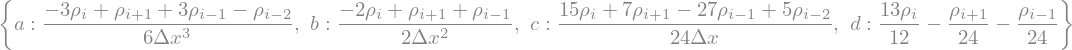

In [11]:
coeffs = solve([A - rm2, B - rm, C - r0, D - rp], [a, b, c, d], check=False)
coeffs

and let's see the polynomial

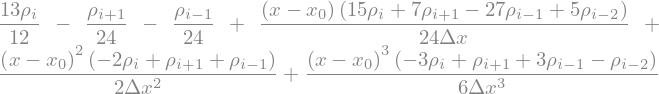

In [12]:
fc = f.subs(a,coeffs[a]).subs(b,coeffs[b]).subs(c,coeffs[c]).subs(d,coeffs[d])
fc

In the paper [_The Piecewise Parabolic Method (PPM) for Gas-dynamical Systems_](https://crd.lbl.gov/assets/pubs_presos/AMCS/ANAG/A141984.pdf) this cubic conservative interpolant is used to find the state on the middle edge of our interval, $x_{i-1/2}$.  Let's evaluate our function there:

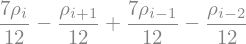

In [13]:
fc.subs(x, x0-Rational(1,2)*dx)

This is equivalent to equation 1.9 in the PPM paper:

$$\rho_{i-1/2} = \frac{7}{12} (\rho_{i-1} + \rho_i) - \frac{1}{12} (\rho_{i-2} + \rho_{i+1})$$

The PPM algorithm is widely-used in astrophysics for modeling hydrodynamics.  Using a conservative interpolant ensure that we are not creating any extra mass when we go from our bin-average values of density to the density at a specific location.